In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import support as sp

from tqdm.auto import tqdm

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

In [2]:
mpl.rc("figure",dpi=150)
mpl.rc("figure",figsize=(3,2))
mpl.rc("text",usetex=True)

In [3]:
%%time 

directory = "/media/Antonio/Dynamic/DimerCurrents/Processed/"

trj_file = os.path.join(directory, "23_08_01_Script10_currents.hdf")
index = pd.read_hdf(trj_file, key = "index")

aggregate = []

subindex = index

def cycle_current(trj_i):
    return trj_i.rolling(20).mean().eval("sqrt(I_x**2+I_y**2)")

for i,entry in tqdm(subindex.iterrows(), total = len(index)):
    trj = pd.read_hdf(trj_file, key = entry.file)

    timeseries = pd.DataFrame(index=pd.Index(trj["time"].unique(),name="time"))
    timeseries["I_x"] = trj.groupby("time").I_x.mean()
    timeseries["I_y"] = trj.groupby("time").I_y.mean()

    trj["I"] = trj.groupby(level=["id"], group_keys=False).apply(cycle_current)

    timeseries["I"] = trj.groupby("time").I.mean()

    timeseries["var_I_x"] = trj.groupby("time").I_x.var()
    timeseries["var_I_y"] = trj.groupby("time").I_y.var()
    timeseries["var_I"] = trj.groupby("time").I.var()
    
    aggregate.append(timeseries)
    
aggregate = pd.concat(aggregate, 
      keys = list(subindex.filter(["tilt","parity","seed"]).itertuples(index=False)),
      names = ["tilt","parity","seed"])

  0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 17min 45s, sys: 3min 44s, total: 21min 29s
Wall time: 2h 57min 4s


In [4]:
aggregate.to_hdf(os.path.join(directory,"23_08_01_Script11_currents_vs_time.hdf"),
                 mode="w", key = "current_vs_time")

## Read Data

In [5]:
%%time
directory = "/media/Antonio/Dynamic/DimerCurrents/Processed"

aggregate_file = os.path.join(directory, "23_08_01_Script11_currents_vs_time.hdf")
data_IvsT = pd.read_hdf(aggregate_file,
                 key = "current_vs_time")
data_IvsT = data_IvsT.reorder_levels(["parity","tilt","seed","time"]).sort_index()

CPU times: user 1.05 s, sys: 736 ms, total: 1.79 s
Wall time: 30.6 s


In [6]:
data_IvsT.head()

I_x        I_y   I    var_I_x   var_I_y  var_I
parity tilt seed  time                                                        
even   0    61169 0.0000        NaN        NaN NaN        NaN       NaN    NaN
                  0.0167  22.159485   6.018671 NaN  19.609173  6.862368    NaN
                  0.0334  20.559523  10.903647 NaN   9.871448  4.742351    NaN
                  0.0501   3.946854   3.128267 NaN   7.338341  6.362692    NaN
                  0.0668  -6.237284  -4.518595 NaN   7.420936  6.416721    NaN

(-0.2, 0.2)

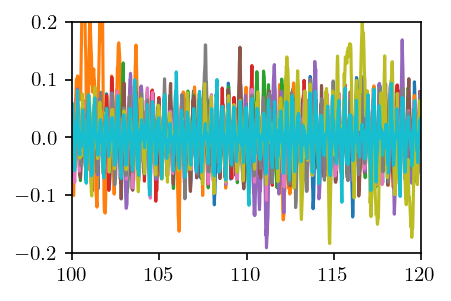

In [7]:
for seed, I_i in data_IvsT.loc[("even",0)].groupby("seed"):
    plt.plot(I_i.loc[seed].I_x.rolling(20).mean())
    
plt.xlim([100,120])
plt.ylim(-0.2,0.2)

In [22]:
currents_aggregate = data_IvsT.groupby(["parity","tilt","time"]).mean()
currents_aggregate[["I_x","I_y"]] = currents_aggregate.rolling(20).mean()[["I_x","I_y"]]
currents_aggregate["var_I"] = data_IvsT.groupby(["parity","tilt","time"]).var().I

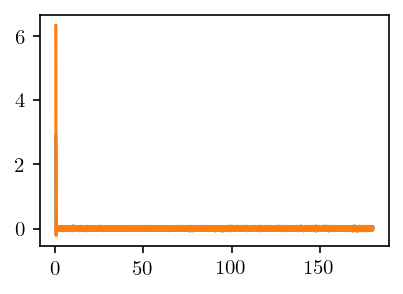

In [23]:
plt.plot(currents_aggregate["I_x"].loc[("even",0)])
plt.plot(currents_aggregate["I_y"].loc[("even",0)])

In [24]:
currents_aggregate.head()

I_x  I_y   I    var_I_x   var_I_y  var_I
parity tilt time                                            
even   0    0.0000  NaN  NaN NaN        NaN       NaN    NaN
            0.0167  NaN  NaN NaN  19.616164  7.644044    NaN
            0.0334  NaN  NaN NaN  10.105327  5.243471    NaN
            0.0501  NaN  NaN NaN   7.511600  6.421853    NaN
            0.0668  NaN  NaN NaN   6.705355  5.989137    NaN

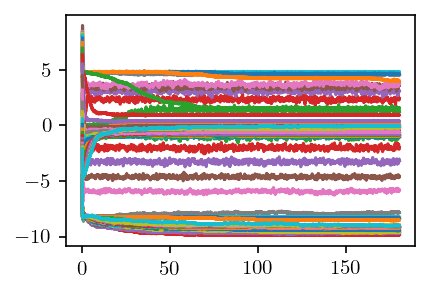

In [25]:
for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):
    L = plt.plot(currents_aggregate.loc["even"].loc[i].I_x)
    plt.plot(currents_aggregate.loc["even"].loc[i].I_y,
            color = L[0].get_color())

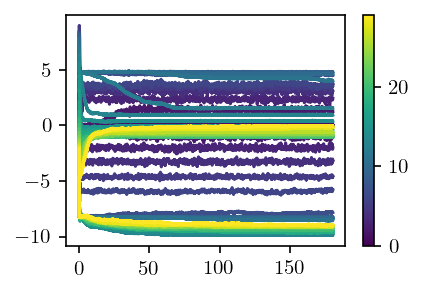

In [26]:
tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):
    plt.plot(currents_aggregate.loc[("even",i)].I_x,
            color = cmap(norm(i)))
    plt.plot(currents_aggregate.loc[("even",i)].I_y,
            color = cmap(norm(i)))
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = plt.gca())

In [27]:
currents_aggregate["I"] = currents_aggregate.eval("sqrt(I_x**2+I_y**2)")

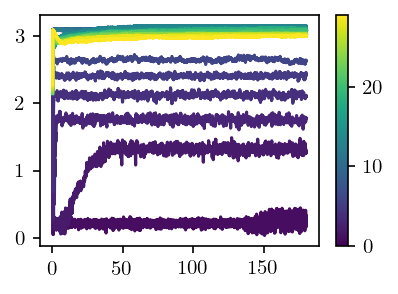

In [28]:
tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):
    
    I = np.sqrt(currents_aggregate.loc[("even",i)].I)

    plt.plot(I,color = cmap(norm(i)))
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = plt.gca())

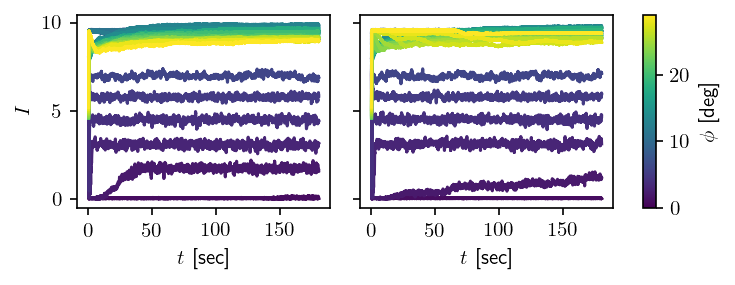

In [29]:
fig, ax = plt.subplots(1,3, figsize=(5,2),
                       width_ratios = [1,1, 0.05],
                       tight_layout=True)

tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):

    ax[0].plot(currents_aggregate.loc[("even",i)].I ,color = cmap(norm(i)))
    
    ax[1].plot(currents_aggregate.loc[("odd",i)].I ,color = cmap(norm(i)))
    
    
ax[0].set_ylabel("$I$")
ax[0].set_xlabel("$t$ [sec]")
ax[1].set_xlabel("$t$ [sec]")

ax[1].set_ylim(ax[0].get_ylim())
ax[1].tick_params("y",labelleft=False)
#ax[1].set_yticks([])
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax = ax[2],
             label = "$\phi$ [deg]")


### Save the smooth dataset

In [30]:
currents_aggregate.to_hdf(aggregate_file,
                 key = "current_vs_time_smooth")

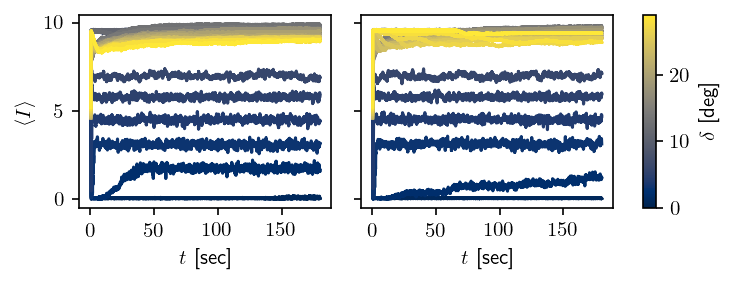

In [38]:
data_IvsT_smooth = pd.read_hdf(aggregate_file,
                 key = "current_vs_time_smooth")

fig, ax = plt.subplots(1,3, figsize=(5,2),
                       width_ratios = [1,1, 0.05],
                       tight_layout=True, facecolor="white")

tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["cividis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for phi in np.sort(tilts):

    ax[0].plot(data_IvsT_smooth.loc["even"].loc[phi].I, color = cmap(norm(phi)))

    ax[1].plot(data_IvsT_smooth.loc["odd"].loc[phi].I, color = cmap(norm(phi)))
    
    
ax[0].set_ylabel(r"$\left<I\right>$")
ax[0].set_xlabel("$t$ [sec]")
ax[1].set_xlabel("$t$ [sec]")

ax[1].set_ylim(ax[0].get_ylim())
ax[1].tick_params("y",labelleft=False)
#ax[1].set_yticks([])
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax = ax[2],
             label = "$\delta$ [deg]")


# Visualize final value of the current vs tilt angle $\phi$

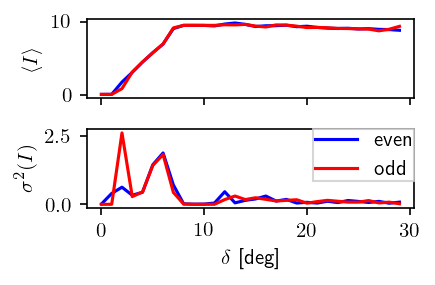

In [37]:
data_IvsPhi = data_IvsT_smooth.query("time>50").groupby(["parity","tilt"]).mean()
#data_IvsPhi_var = data_IvsT_smooth.query("time>50").groupby(["parity","tilt"]).var()

fig, ax = plt.subplots(2,1, sharex=True,
                       figsize=(3,2), facecolor="white",
                       tight_layout=True)

color = ["blue","red"]

ax[0].plot(data_IvsPhi.loc["even"].I,color = color[0])
ax[0].plot(data_IvsPhi.loc["odd"].I,color = color[1])


ax[1].plot(data_IvsPhi_var.loc["even"].var_I, color[0], label="even")
ax[1].plot(data_IvsPhi_var.loc["odd"].var_I, color[1], label="odd")

ax[1].set_xlabel("$\delta$ [deg]")
ax[1].set_ylabel("$\sigma^2(I)$")
ax[0].set_ylabel(r"$\left<I\right>$")

ax[1].legend(
    fancybox=False,
    borderpad=0.1,
    bbox_to_anchor=(1,1),borderaxespad=0
            )